In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from scipy.optimize import minimize

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# Preview the data
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
# Separate target from features
y = train['target']
features = train.drop(['id','target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,B,B,B,C,B,B,A,E,C,N,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,B,B,A,A,B,D,A,F,A,O,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,A,A,A,C,B,D,A,D,A,F,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,B,B,A,C,B,D,A,E,C,K,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,A,A,A,C,B,D,A,E,A,N,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


# Preprocessing

In [6]:
'''
# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# ordinal-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()
'''

"\n# List of categorical columns\nobject_cols = [col for col in features.columns if 'cat' in col]\n\n# ordinal-encode categorical columns\nX = features.copy()\nX_test = test.drop(['id'], axis=1).copy()\nordinal_encoder = OrdinalEncoder()\nX[object_cols] = ordinal_encoder.fit_transform(features[object_cols])\nX_test[object_cols] = ordinal_encoder.transform(test[object_cols])\n\n# Preview the ordinal-encoded features\nX.head()\n"

In [7]:

# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# one-hot-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()

oh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_ohe = oh_encoder.fit_transform(features[object_cols])
X_test_ohe = oh_encoder.transform(test[object_cols])

X_ohe = pd.DataFrame(X_ohe, columns=[f"ohe_{i}" for i in range(X_ohe.shape[1])])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])

X = pd.concat([X, X_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X = X.drop(object_cols, axis=1)
X_test = X_test.drop(object_cols, axis=1)
    
# Preview the one-hot-encoded features
X.head()


,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,ohe_46,ohe_47,ohe_48,ohe_49,ohe_50,ohe_51,ohe_52,ohe_53,ohe_54,ohe_55
0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
scale_features = [col for col in features.columns if 'cont' in col]

ss = StandardScaler()
X[scale_features] = ss.fit_transform(features[scale_features])
X_test[scale_features] = ss.transform(test[scale_features])

In [9]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Pseudo Label

In [10]:
pseudo = pd.read_csv("../input/30-days-pseudo/submission.csv")[target]
train_pseudo = pd.concat([X, y], axis=1)
test_pseudo = pd.concat([X_test, pseudo], axis=1)
all_pseudo = pd.concat([train_pseudo, test_pseudo]).reset_index(drop=True)

# XGB

In [11]:
xgb_params = {
    'objective': 'reg:squarederror',
   'n_estimators': N_ESTIMATORS,
    'importance_type': 'total_gain',
    'tree_method': 'hist',
      
    'learning_rate': 0.015009683406092125, 
    'subsample': 0.8860984541407548, 
    'colsample_bytree': 0.11361557231895411, 
    'max_depth': 6, 
    'lambda': 29.103801673368366,
    'alpha': 28.67297268600769,
    'min_child_weight': 333.64047917343476
        
}

In [12]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo.iloc[:,:-1], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    
    oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
    preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])
    
    X_train, y_train = all_pseudo.iloc[trn_idx, :-1], all_pseudo[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)
    
    X_valid, y_valid = all_pseudo.iloc[oof_idx, :-1], all_pseudo[target].iloc[oof_idx]
    X_test = all_pseudo.iloc[preds_idx, :-1]
    
    # XGB
    start = time.time()
    
    for inseed in seed_list:
        xgb_params['random_state'] = inseed
    
        pre_model = xgb.XGBRegressor(**xgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE
        )

        xgb_params2 = xgb_params.copy()
        xgb_params2['lambda'] *= 0.9
        xgb_params2['alpha'] *= 0.9
        xgb_params2['learning_rate'] *= 0.1
        model = xgb.XGBRegressor(**xgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='rmse',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                xgb_model=pre_model
        )    

        with open(f"lgb_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        xgb_importances = xgb_importances.append(fi_tmp)

        xgb_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
        xgb_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)
    
    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, xgb_oof[oof_idx], squared=False)
    print(f"fold {fold} - xgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof xgb_rmse = {mean_squared_error(train[target], xgb_oof, squared=False)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
[0]	validation_0-rmse:7.65872
[1000]	validation_0-rmse:0.71872
[2000]	validation_0-rmse:0.71371
[3000]	validation_0-rmse:0.71223
[4000]	validation_0-rmse:0.71161
[5000]	validation_0-rmse:0.71125
[6000]	validation_0-rmse:0.71104
[7000]	validation_0-rmse:0.71092
[8000]	validation_0-rmse:0.71083
[9000]	validation_0-rmse:0.71078
[9522]	validation_0-rmse:0.71077
[0]	validation_0-rmse:0.71077
[201]	validation_0-rmse:0.71077
[0]	validation_0-rmse:7.65872
[1000]	validation_0-rmse:0.71901
[2000]	validation_0-rmse:0.71379
[3000]	validation_0-rmse:0.71221
[4000]	validation_0-rmse:0.71152
[5000]	validation_0-rmse:0.71117
[6000]	validation_0-rmse:0.71096
[7000]	validation_0-rmse:0.71081
[8000]	validation_0-rmse:0.71072
[8799]	validation_0-rmse:0.71068
[0]	validation_0-rmse:0.71068
[200]	validation_0-rmse:0.71069
[0]	validation_0-rmse:7.65872
[1000]	validation_0-rmse:0.71881
[2000]	validation_0-rmse:0.71375
[3000]	validation_0-rmse:0.71220
[4000]	validation_0-rmse:0.71156
[5000]	v

# OOF predictions

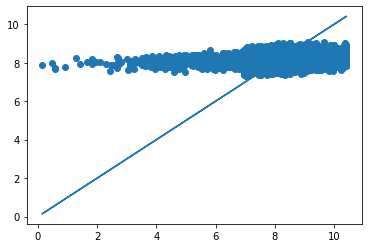

In [13]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

# Features importances

Text(0.5, 1.0, 'XGB feature importances')

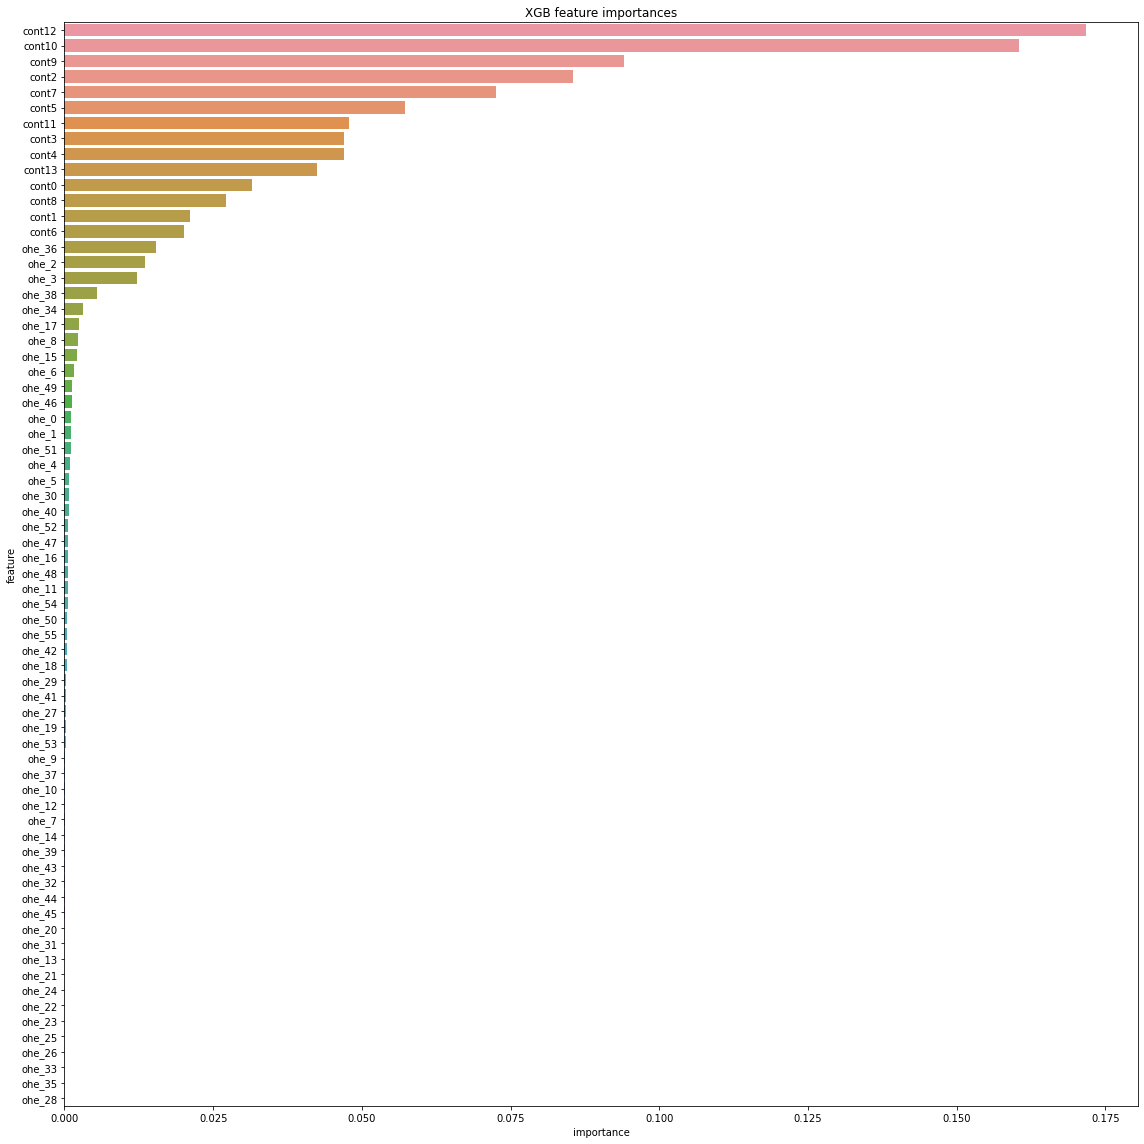

In [14]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGB feature importances")

# Submission

In [15]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,0,8.088469
1,5,8.392719
2,15,8.404328
3,16,8.509552
4,17,8.150654
...,...,...
199995,499987,8.030640
199996,499990,8.470766
199997,499991,8.531893
199998,499994,8.171848
